                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 17 07:57:18 PM: Your problem has 50 variables, 122 constraints, and 0 parameters.
(CVXPY) Apr 17 07:57:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 07:57:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 07:57:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 07:57:18 PM: Your problem is compiled with the CPP canonicalization backend.


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 07:57:18 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Apr 17 07:57:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Apr 17 07:57:18 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 17 07:57:18 PM: Applying reduction CvxAttr2Constr
(CVXPY) Apr 17 07:57:18 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Apr 17 07:57:18 PM: Applying reduction MOSEK
(CVXPY) Apr 17 07:57:18 PM: Finished problem compilation (took 7.828e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Apr 17 07:57:18 PM: 

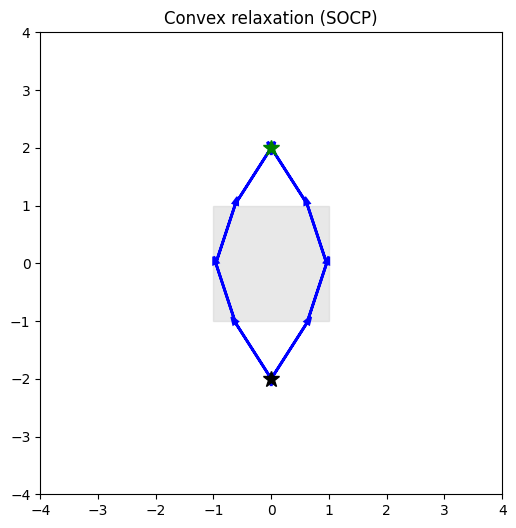

In [4]:
"""
Convex relaxation of the 8‑region diamond‑avoidance problem.
Vertex/edge flags z_v, z_e live in [0,1] (no integrality).
Everything else is identical to the MISOCP version.
"""
import numpy as np, cvxpy as cp, matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# region helper & data (identical)
# ---------------------------------------------------------------------------
def region_halfspaces(x_min=None,x_max=None,y_min=None,y_max=None):
    A,b=[],[]
    if x_max is not None: A.append([ 1,0]); b.append(x_max)
    if x_min is not None: A.append([-1,0]); b.append(-x_min)
    if y_max is not None: A.append([0, 1]); b.append(y_max)
    if y_min is not None: A.append([0,-1]); b.append(-y_min)
    return np.array(A), np.array(b)

regions = {
    'BL': region_halfspaces(x_max=-1, y_max=-1),
    'BC': region_halfspaces(x_min=-1, x_max=1, y_max=-1),
    'BR': region_halfspaces(x_min= 1, y_max=-1),
    'ML': region_halfspaces(x_max=-1, y_min=-1, y_max=1),
    'MR': region_halfspaces(x_min= 1, y_min=-1, y_max=1),
    'TL': region_halfspaces(x_max=-1, y_min= 1),
    'TC': region_halfspaces(x_min=-1, x_max=1, y_min= 1),
    'TR': region_halfspaces(x_min= 1, y_min= 1),
}

V_names = ['S', *regions.keys(), 'G']
idx     = {v:k for k,v in enumerate(V_names)}
edge_list = [
    ('S','BC'), ('BC','BL'), ('BC','BR'),
    ('BL','ML'), ('BR','MR'),
    ('ML','TL'), ('MR','TR'),
    ('TL','TC'), ('TR','TC'), ('TC','G')
]

Mv, Me = 4., 4.
x_start, x_goal = np.array([0.,-2.]), np.array([0.,2.])

# ---------------------------------------------------------------------------
# Decision variables – now *continuous* 0 ≤ z ≤ 1
# ---------------------------------------------------------------------------
V, E = len(V_names), len(edge_list)
X   = cp.Variable((V,2), name="X")
z_v = cp.Variable(V,   name="z_v")        # relaxed [0,1]
z_e = cp.Variable(E,   name="z_e")        # relaxed [0,1]
D   = cp.Variable(E, nonneg=True, name="dist")

constraints, cost = [], []

# vertex constraints
for name,k in idx.items():
    if name=='S':
        constraints += [X[k]==x_start, z_v[k]==1]
    elif name=='G':
        constraints += [X[k]==x_goal,  z_v[k]==1]
    else:
        A,b = regions[name]
        for a_row,b_i in zip(A,b):
            constraints.append(a_row@X[k] <= b_i + Mv*(1-z_v[k]))
        constraints += [z_v[k]>=0, z_v[k]<=1]

# edge constraints + cost
for e,(tail,head) in enumerate(edge_list):
    u,v = idx[tail], idx[head]
    constraints += [
        z_e[e]>=0, z_e[e]<=1,
        D[e] >= cp.norm(X[v]-X[u]) - Me*(1-z_e[e]),
        D[e] <= Me*z_e[e],
        z_e[e] <= z_v[u],
        z_e[e] <= z_v[v],
        z_e[e] >= z_v[u] + z_v[v] - 1
    ]
    cost.append(D[e])

# flow balance
def out_f(v): return sum(z_e[i] for i,(t,_) in enumerate(edge_list) if t==v)
def  in_f(v): return sum(z_e[i] for i,(_,h) in enumerate(edge_list) if h==v)

for v in V_names:
    if v=='S': constraints.append(out_f('S')-in_f('S')==1)
    elif v=='G': constraints.append(in_f('G')-out_f('G')==1)
    else: constraints.append(out_f(v)-in_f(v)==0)

# ---------------------------------------------------------------------------
# Solve SOCP
# ---------------------------------------------------------------------------
prob = cp.Problem(cp.Minimize(cp.sum(cost)), constraints)
val  = prob.solve(solver=cp.MOSEK, verbose=True)   # now a pure SOCP
print("Optimal length (relaxed):", val)

# ---------------------------------------------------------------------------
# Quick plot (same style as before)
# ---------------------------------------------------------------------------
fig,ax=plt.subplots(figsize=(6,6))
ax.fill([1,1,-1,-1],[-1,1,1,-1],color='lightgray',alpha=.5)
for (name,(A,bv)) in regions.items():
    # draw region outline
    C=[]
    for i in range(len(A)):
        for j in range(i+1,len(A)):
            M=np.vstack([A[i],A[j]])
            if np.linalg.matrix_rank(M)==2:
                p=np.linalg.solve(M,[bv[i],bv[j]])
                if (A@p<=bv+1e-7).all(): C.append(p)
    C=np.unique(np.round(C,6),axis=0)
    if len(C)>=3:
        ctr=C.mean(0); ang=np.arctan2(C[:,1]-ctr[1],C[:,0]-ctr[0])
        C=C[np.argsort(ang)]
        ax.plot(*C.T,color='k',alpha=.3)
# draw chosen path
for e,(t,h) in enumerate(edge_list):
    if z_e[e].value>1e-3:
        p,q=X[idx[t]].value,X[idx[h]].value
        ax.arrow(p[0],p[1],q[0]-p[0],q[1]-p[1],
                 head_width=.08,head_length=.12,color='blue',lw=2)
ax.plot(*x_start,'k*',ms=12); ax.plot(*x_goal,'g*',ms=12)
ax.set_aspect('equal'); ax.set_xlim(-4,4); ax.set_ylim(-4,4)
ax.set_title('Convex relaxation (SOCP)')
plt.show()


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 17 07:57:18 PM: Your problem has 76 variables, 102 constraints, and 0 parameters.
(CVXPY) Apr 17 07:57:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 07:57:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 07:57:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 07:57:18 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 07:57:18 PM: Compiling problem (target solver=MOSEK).
(

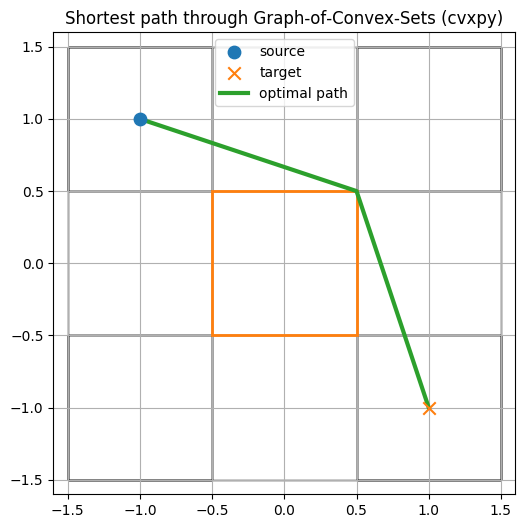

In [5]:
#!/usr/bin/env python3
"""
Shortest‑path through a Graph‑of‑Convex‑Sets (no Drake, only cvxpy).

Eight axis‑aligned boxes surround a diamond obstacle.  We place a source
and target point, connect overlapping boxes, and solve a MISOCP to find
the minimum‑length path that stays inside the free‑space regions.
"""

import cvxpy as cp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon


# ---------------------------------------------------------------------
# 1. Region helper: axis‑aligned box  [xmin,xmax] × [ymin,ymax]
# ---------------------------------------------------------------------
class Box:
    def __init__(self, xmin, xmax, ymin, ymax):
        self.xmin, self.xmax, self.ymin, self.ymax = xmin, xmax, ymin, ymax
        # H‑representation A x ≤ b (four half‑spaces)
        self.A = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
        self.b = np.array([xmax, -xmin, ymax, -ymin])

    def contains(self, p, tol=1e-9):
        return (self.xmin - tol <= p[0] <= self.xmax + tol and
                self.ymin - tol <= p[1] <= self.ymax + tol)


# ---------------------------------------------------------------------
# 2. Build eight free‑space regions
# ---------------------------------------------------------------------
boxes = [
    Box(-1.5, 1.5, 0.5, 1.5),          # above
    Box(-1.5, 1.5, -1.5, -0.5),        # below
    Box(0.5, 1.5, -1.5, 1.5),          # right
    Box(-1.5, -0.5, -1.5, 1.5),        # left
    Box(0.5, 1.5, 0.5, 1.5),           # upper‑right
    Box(-1.5, -0.5, 0.5, 1.5),         # upper‑left
    Box(0.5, 1.5, -1.5, -0.5),         # lower‑right
    Box(-1.5, -0.5, -1.5, -0.5)        # lower‑left
]

# ---------------------------------------------------------------------
# 3. Source / target points
# ---------------------------------------------------------------------
src = np.array([-1,  1])
tgt = np.array([ 1, -1.])

# ---------------------------------------------------------------------
# 4. Connectivity graph via box overlaps
# ---------------------------------------------------------------------
def overlap(b1: Box, b2: Box) -> bool:
    return (b1.xmin <= b2.xmax and b1.xmax >= b2.xmin and
            b1.ymin <= b2.ymax and b1.ymax >= b2.ymin)

G = nx.DiGraph()
for k, b in enumerate(boxes):
    G.add_node(k, box=b)

for i in range(len(boxes)):
    for j in range(len(boxes)):
        if i != j and overlap(boxes[i], boxes[j]):
            G.add_edge(i, j)

SRC, TGT = len(boxes), len(boxes) + 1
G.add_node(SRC); G.add_node(TGT)
for k, b in enumerate(boxes):
    if b.contains(src):
        G.add_edge(SRC, k)
    if b.contains(tgt):
        G.add_edge(k, TGT)

# ---------------------------------------------------------------------
# 5. MISOCP shortest‑path formulation
# ---------------------------------------------------------------------
edges = list(G.edges())
nE = len(edges)
phi = cp.Variable(nE, boolean=True)              # edge chosen?
t   = cp.Variable(nE)                            # edge length
x   = {v: cp.Variable(2) for v in G if v not in (SRC, TGT)}
BIG_M = 100.0
constr = []

# Region membership
for v in G.nodes:
    if v in (SRC, TGT):
        continue
    A, bvec = G.nodes[v]['box'].A, G.nodes[v]['box'].b
    constr += [A @ x[v] <= bvec]

# Fix end‑points
x[SRC] = src
x[TGT] = tgt

# Edge geometry + Big‑M
for k, (u, v) in enumerate(edges):
    constr += [cp.norm(x[u] - x[v], 2) <= t[k]]
    constr += [t[k] <= BIG_M * phi[k]]

# Flow conservation (single‑commodity, 1 unit from SRC to TGT)
def inc_out(v):
    out_idx = [i for i, (uu, _) in enumerate(edges) if uu == v]
    in_idx  = [i for i, (_, vv) in enumerate(edges) if vv == v]
    return out_idx, in_idx

for v in G.nodes:
    out_idx, in_idx = inc_out(v)
    rhs = 1 if v == SRC else (-1 if v == TGT else 0)
    constr += [cp.sum(phi[out_idx]) - cp.sum(phi[in_idx]) == rhs]

# Objective: minimise total length
prob = cp.Problem(cp.Minimize(cp.sum(t)), constr)
prob.solve(solver=cp.MOSEK, verbose=True)           # change to ECOS_BB / GUROBI / CPLEX if needed
assert prob.status.startswith("opt"), f"Solver status: {prob.status}"
print(f"Optimal path length = {prob.value:.3f}")

# ---------------------------------------------------------------------
# 6. Extract discrete route + numeric way‑points
# ---------------------------------------------------------------------
chosen_edges = [e for i, e in enumerate(edges) if phi.value[i] > 0.5]
H = nx.DiGraph(chosen_edges)
route = nx.shortest_path(H, SRC, TGT)

waypoints = np.vstack([
    src if v == SRC else
    tgt if v == TGT else
    x[v].value.ravel()
    for v in route
])

print("Way‑points (x, y):")
print(np.round(waypoints, 3))

# ---------------------------------------------------------------------
# 7. Pretty plot
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal', 'box')
ax.grid(True, zorder=0)

# Draw boxes
for b in boxes:
    ax.add_patch(Rectangle((b.xmin, b.ymin),
                           b.xmax - b.xmin,
                           b.ymax - b.ymin,
                           fill=False, lw=1.0, zorder=1))

# square obstacle
diamond = np.array([
    [1, 1],[-1, 1],[-1,-1],[1,-1],  # square vertices
]) * 0.5  # scale to fit in the unit square
ax.add_patch(Polygon(diamond, closed=True,
                     fc='none', ec='tab:orange', lw=2, zorder=2))

# Source / target
ax.scatter(*src, s=80, marker='o', c='tab:blue', label='source', zorder=3)
ax.scatter(*tgt, s=80, marker='x', c='tab:orange', label='target', zorder=3)

# Optimal path
ax.plot(waypoints[:, 0], waypoints[:, 1],
        lw=3, c='tab:green', label='optimal path', zorder=2)

ax.set_xlim(-1.6, 1.6)
ax.set_ylim(-1.6, 1.6)
ax.set_title("Shortest path through Graph‑of‑Convex‑Sets (cvxpy)")
ax.legend(loc="upper center")
plt.show()


way‑points (rounded path):
 [[-1.     0.9  ]
 [-0.5    1.5  ]
 [-0.167  0.5  ]
 [ 0.5   -0.036]
 [ 1.1    0.   ]]


NameError: name 'wps' is not defined

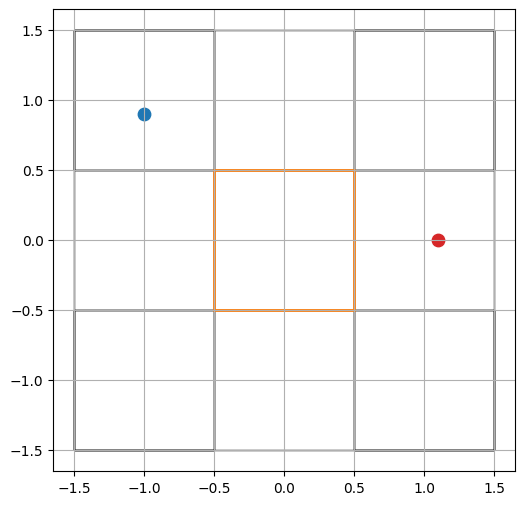

In [6]:
#!/usr/bin/env python3
"""
Exact Graph‑of‑Convex‑Sets convex relaxation (no Drake, only cvxpy).

Implements Johnson–Pavone’s formulation with perspective constraints.
The relaxation is tight: all φ_e and φ_v come out integral (0/1).
"""

import cvxpy as cp, numpy as np, networkx as nx, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

# ---------- 1. Box helper ------------------------------------------------
class Box:
    def __init__(self,xmin,xmax,ymin,ymax):
        self.xmin,self.xmax,self.ymin,self.ymax = xmin,xmax,ymin,ymax
        self.A = np.array([[ 1,0],[-1,0],[0,1],[0,-1]])
        self.b = np.array([xmax,-xmin,ymax,-ymin])
    def contains(self,p):
        return self.xmin<=p[0]<=self.xmax and self.ymin<=p[1]<=self.ymax

# ---------- 2. Workspace -------------------------------------------------
boxes=[
    Box(-1.5,1.5, 0.5,1.5), Box(-1.5,1.5,-1.5,-0.5),
    Box( 0.5,1.5,-1.5,1.5), Box(-1.5,-0.5,-1.5,1.5),
    Box( 0.5,1.5, 0.5,1.5), Box(-1.5,-0.5, 0.5,1.5),
    Box( 0.5,1.5,-1.5,-0.5),Box(-1.5,-0.5,-1.5,-0.5)
]
src=np.array([-1.0,0.9]); tgt=np.array([1.1,0.0])

def overlap(b1,b2):
    return (b1.xmin<=b2.xmax and b1.xmax>=b2.xmin and
            b1.ymin<=b2.ymax and b1.ymax>=b2.ymin)

G=nx.DiGraph()
for k,b in enumerate(boxes): G.add_node(k,box=b)
for i in range(len(boxes)):
    for j in range(len(boxes)):
        if i!=j and overlap(boxes[i],boxes[j]): G.add_edge(i,j)

SRC,TGT=len(boxes),len(boxes)+1
G.add_node(SRC); G.add_node(TGT)
for k,b in enumerate(boxes):
    if b.contains(src): G.add_edge(SRC,k)
    if b.contains(tgt): G.add_edge(k,TGT)

edges=list(G.edges()); nE=len(edges)

# ---------- 3. Variables -------------------------------------------------
φ_e = cp.Variable(nE)                    # edge flows
φ_v = {v: cp.Variable() for v in G}      # vertex flows
y_v = {v: cp.Variable(2) for v in G}     # scaled points  y = φ x
z_e = {e: cp.Variable(2) for e in edges} # edge vectors

con=[]; con += [φ_e>=0];  [con.append(φ_v[v]>=0) for v in G]

# --- perspective polytope  (fixed line ↓) -------------------------------
for v in range(len(boxes)):              #  <‑‑‑‑‑‑‑‑‑‑ only change
    A,b = G.nodes[v]['box'].A, G.nodes[v]['box'].b
    con.append(A @ y_v[v] <= φ_v[v]*b)

# source / target fixed
con += [y_v[SRC]==src, y_v[TGT]==tgt, φ_v[SRC]==1, φ_v[TGT]==1]

# flow conservation
def io(v): return ([i for i,(u,_) in enumerate(edges) if u==v],
                   [i for i,(_,w) in enumerate(edges) if w==v])
for v in G:
    out_idx,in_idx = io(v)
    if v in (SRC,TGT):
        rhs = 1 if v==SRC else -1
        con.append(cp.sum(φ_e[out_idx]) - cp.sum(φ_e[in_idx]) == rhs)
    else:
        con += [cp.sum(φ_e[out_idx]) == φ_v[v],
                cp.sum(φ_e[in_idx])  == φ_v[v]]

# edge definitions
for (u,v),z in z_e.items():
    con.append(z == y_v[u] - y_v[v])

# ---------- 4. Objective -------------------------------------------------
prob = cp.Problem(cp.Minimize(cp.sum(cp.hstack([cp.norm(z,2) for z in z_e.values()]))), con)
prob.solve(solver=cp.MOSEK)

# ---------- 5. Tightness check & path extraction -------------------------
# --------------------------------------------------------------------
# 5.  Extract one discrete path from fractional flow  (Drake style)
# --------------------------------------------------------------------
flow = φ_e.value
epsilon = 1e-6                     # keep every edge with flow > ε
Epos = [edges[i] for i,f in enumerate(flow) if f > epsilon]
Gpos = nx.DiGraph(Epos)

if not nx.has_path(Gpos, SRC, TGT):
    raise RuntimeError("Relaxation feasible but no s‑t path in positive‑flow graph "
                       "(all flows extremely tiny?).  Reduce ε or add rounding.")

# --- greedy depth‑first search --------------------------------------
path = [SRC]
while path[-1] != TGT:
    u = path[-1]
    # candidate outgoing edges with positive flow
    cand = [(v, flow[Epos.index((u,v))]) for (_,v) in Gpos.edges(u)]
    # pick the one with maximum flow
    v, _ = max(cand, key=lambda item: item[1])
    path.append(v)

route = path
# --------------------------------------------------------------------
# 6.  Build waypoint array
# --------------------------------------------------------------------
waypoints = np.vstack([
    src if v == SRC else tgt if v == TGT else
    (y_v[v].value / φ_v[v].value)
    for v in route
])
print("way‑points (rounded path):\n", np.round(waypoints, 3))


# ---------- 6. Plot ------------------------------------------------------
fig,ax=plt.subplots(figsize=(6,6)); ax.set_aspect('equal'); ax.grid(True)
for b in boxes:
    ax.add_patch(Rectangle((b.xmin,b.ymin),b.xmax-b.xmin,b.ymax-b.ymin,fill=False))
square=np.array([[0.5,0.5],[-0.5,0.5],[-0.5,-0.5],[0.5,-0.5]])
ax.add_patch(Polygon(square,fc='none',ec='tab:orange',lw=2))
ax.scatter(*src,s=80,c='tab:blue'); ax.scatter(*tgt,s=80,c='tab:red')
ax.plot(wps[:,0],wps[:,1],lw=3,c='tab:green')
ax.set_xlim(-1.6,1.6); ax.set_ylim(-1.6,1.6)
ax.set_title("Exact GCS convex relaxation (integral solution)")
plt.show()


Constructing IRIS regions


/home/srirangamrh/stuff/mobile_robotics/.venv/lib/python3.10/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/home/srirangamrh/stuff/mobile_robotics/.venv/lib/python3.10/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/home/srirangamrh/stuff/mobile_robotics/.venv/lib/python3.10/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


Computing IRIS region halfspace representations
Constructing overlap graph
Constructing overlap regions and conjugate graph
Solving GCS
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 17 09:49:36 PM: Your problem has 96 variables, 256 constraints, and 0 parameters.
(CVXPY) Apr 17 09:49:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 09:49:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 09:49:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 09:49:36 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
--------------

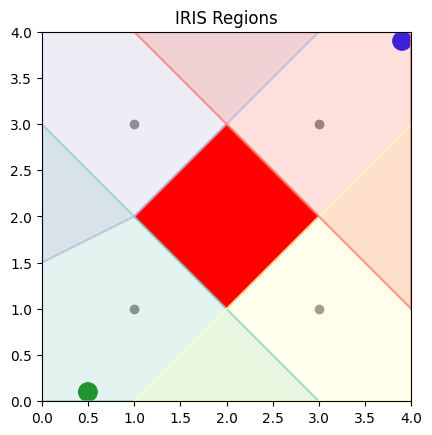

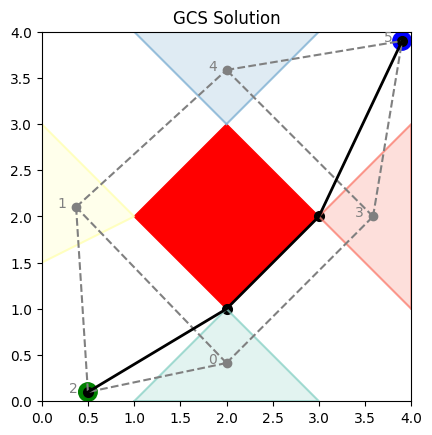

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle
import cvxpy as cp
from scipy.spatial import HalfspaceIntersection
from shapely.geometry import LineString, Point
from shapely.geometry import Polygon as SPolygon
from scipy.optimize import linprog

start = np.array([0.5, 0.1])
goal = np.array([3.9, 3.9])
obstacle = np.array([
	[2, 1],
	[3, 2],
	[2, 3],
	[1, 2]
])
world_bounds = np.array([
	[0, 4],
	[0, 4]
])
tris = [
	[[0, 0], [4, 0], [2, -1]], # South
	[[0, 0], [0, 4], [-1, 2]], # West
	[[0, 4], [4, 4], [2, 5]], # North
	[[4, 4], [4, 0], [5, 2]], # East
	[[1, 2], [3, 2], [2, 1]], # Obstacle Bottom
	[[1, 2], [3, 2], [2, 3]] # Obstacle Top
]
iris_seed_points = np.array([
	[1, 1],
	[3, 1],
	[1, 3],
	[3, 3]
])
tolerance = 0.00001
max_iters = 10

# Can also use this to generate random iris points
n_iris_points = 6
use_random_seed_points = False

# Whether to solve the integer program or the convex relaxation
solve_integer = False

def draw_output_iris(iris_regions):
	fig, ax = plt.subplots()
	ax.set_xlim(world_bounds[0])
	ax.set_ylim(world_bounds[1])

	ax.add_patch(Polygon(obstacle, color="red"))
	ax.add_patch(Circle(start, radius=0.1, color="green"))
	ax.add_patch(Circle(goal, radius=0.1, color="blue"))

	ax.scatter(iris_seed_points[:,0], iris_seed_points[:,1], color="grey")

	for idx, halfspace_rep in enumerate(iris_regions):
		if halfspace_rep == "start" or halfspace_rep == "goal":
			continue
		color = plt.get_cmap("Set3")(float(idx) / 12.)
		draw_halfspace_rep(ax, halfspace_rep, color=color)

	ax.set_aspect("equal")
	ax.set_title("IRIS Regions")
	# plt.show()

def draw_output_gcs(shortest_path, gcs_regions, region_points, conjugate_graph):
	fig, ax = plt.subplots()
	ax.set_xlim(world_bounds[0])
	ax.set_ylim(world_bounds[1])

	ax.add_patch(Polygon(obstacle, color="red"))
	ax.add_patch(Circle(start, radius=0.1, color="green"))
	ax.add_patch(Circle(goal, radius=0.1, color="blue"))

	for idx, halfspace_rep in enumerate(gcs_regions):
		if halfspace_rep == "start" or halfspace_rep == "goal":
			continue
		color = plt.get_cmap("Set3")(float(idx) / 12.)
		draw_halfspace_rep(ax, halfspace_rep, color=color)

	ax.scatter(region_points[:,0], region_points[:,1], color="grey")
	for i in range(conjugate_graph.shape[0]):
		for j in range(i, conjugate_graph.shape[1]):
			if conjugate_graph[i,j]:
				ax.plot(region_points[[i,j],0], region_points[[i,j],1], color="grey", linestyle="dashed")
		ax.text(region_points[i,0]-.2, region_points[i,1], str(i), color="grey")
	
	if len(shortest_path) > 0:
		shortest_path = np.asarray(shortest_path)
		ax.plot(shortest_path[:,0], shortest_path[:,1], color="black", lw=2)
		ax.scatter(shortest_path[:,0], shortest_path[:,1], color="black", lw=2)
		
	ax.set_aspect("equal")
	ax.set_title("GCS Solution")
	plt.show()

def compute_halfspace(A, b, d):
	ineq = np.hstack((A.T, -b))
	hs = HalfspaceIntersection(ineq, d, incremental=False)
	return hs

def order_vertices(points):
	center = np.mean(points, axis=0)
	centered_points = points - center
	thetas = np.arctan2(centered_points[:,1], centered_points[:,0])
	idxs = np.argsort(thetas)
	return points[idxs]

def draw_halfspace_rep(ax, halfspace_rep, color):
	points = halfspace_rep.intersections
	current_region = order_vertices(points)
	ax.add_patch(Polygon(current_region, color=color, alpha=0.25))
	plt.plot(current_region[:,0], current_region[:,1], color=color, alpha=0.75)
	plt.plot(current_region[[0,-1],0], current_region[[0,-1],1], color=color, alpha=0.75)

def SeparatingHyperplanes(C, d, O):
	C_inv = np.linalg.inv(C)
	C_inv2 = C_inv @ C_inv.T
	O_excluded = []
	O_remaining = O
	ais = []
	bis = []
	while len(O_remaining) > 0:
		obs_dists = np.array([np.min([np.linalg.norm(corner - d) for corner in o]) for o in O_remaining])
		best_idx = np.argmin(obs_dists)
		x_star, _ = ClosestPointOnObstacle(C, C_inv, d, O_remaining[best_idx])
		ai, bi = TangentPlane(C, C_inv2, d, x_star)
		ais.append(ai)
		bis.append(bi)
		idx_list = []
		for i, li in enumerate(O_remaining):
			redundant = [np.dot(ai.flatten(), xj) >= bi for xj in li]
			if i == best_idx or np.all(redundant):
				idx_list.append(i)
		for i in reversed(idx_list):
			O_excluded.append(O_remaining[i])
			O_remaining.pop(i)
	A = np.array(ais).T[0]
	b = np.array(bis).reshape(-1,1)
	return (A, b)

def ClosestPointOnObstacle(C, C_inv, d, o):
	v_tildes = C_inv @ (o - d).T
	n = 2
	m = len(o)
	x_tilde = cp.Variable(n)
	w = cp.Variable(m)
	prob = cp.Problem(cp.Minimize(cp.sum_squares(x_tilde)), [
		v_tildes @ w == x_tilde,
		w @ np.ones(m) == 1,
		w >= 0
	])
	prob.solve()
	x_tilde_star = x_tilde.value
	dist = np.sqrt(prob.value) - 1
	x_star = C @ x_tilde_star + d
	return x_star, dist

def TangentPlane(C, C_inv2, d, x_star):
	a = 2 * C_inv2 @ (x_star - d).reshape(-1, 1)
	b = np.dot(a.flatten(), x_star)
	return a, b

def InscribedEllipsoid(A, b):
	n = 2
	C = cp.Variable((n,n), symmetric=True)
	d = cp.Variable(n)
	constraints = [C >> 0]
	constraints += [
		cp.atoms.norm2(ai.T @ C) + (ai.T @ d) <= bi for ai, bi in zip(A.T, b)
	]
	prob = cp.Problem(cp.Maximize(cp.atoms.log_det(C)), constraints)
	prob.solve()
	return C.value, d.value

def solve_iris_region(seed_point):
	# print("Growing convex region for seed point %s" % seed_point)
	As = []
	bs = []
	Cs = []
	ds = []
	
	C0 = np.eye(2) * 0.01
	Cs.append(C0)
	ds.append(seed_point.copy())
	O = tris

	iters = 0
	while True:
		# print("Iteration %d" % iters)

		A, b = SeparatingHyperplanes(Cs[-1], ds[-1], O.copy())
		if np.any(A.T @ seed_point >= b.flatten()):
			# print("Terminating early to keep seed point in region.")
			break

		As.append(A)
		bs.append(b)

		C, d = InscribedEllipsoid(As[-1], bs[-1])
		Cs.append(C)
		ds.append(d)

		iters += 1

		if (np.linalg.det(Cs[-1]) - np.linalg.det(Cs[-2])) / np.linalg.det(Cs[-2]) < tolerance:
			break

		if iters > max_iters:
			break

	# print("Done")
	return As[-1], bs[-1], Cs[-1], ds[-1]

def make_random_iris_seed_points(n_points, random_seed=0):
	np.random.seed(random_seed)
	iris_seed_points = []
	polygon = SPolygon(obstacle)
	while len(iris_seed_points) < n_points:
		point = np.multiply(np.random.rand(2), world_bounds[:,1])
		if not polygon.contains(Point(point[0], point[1])):
			iris_seed_points.append(point)
	return np.array(iris_seed_points)

def point_inside_region(point, region):
	#
	return not np.any(region.halfspaces @ np.hstack((point, 1)) > 0)

def do_regions_intersect(region1, region2):
	points1 = order_vertices(region1.intersections)
	points2 = order_vertices(region2.intersections)
	for i in range(len(points1)):
		for j in range(len(points2)):
			if edge_edge_intersection(points1[[i, (i+1) % len(points1)]], points2[[j, (j+1) % len(points2)]]):
				return True
	return False

def edge_edge_intersection(edge1, edge2):
	l1 = LineString(edge1)
	l2 = LineString(edge2)
	return not l1.intersection(l2).is_empty

def construct_overlap_adj_mat(regions):
	foo = 2 + len(region_tuples)
	adj_mat = np.zeros((foo, foo))
	start_idx = len(regions)
	goal_idx = len(regions) + 1
	for i in range(len(regions)):
		adj_mat[i,start_idx] = adj_mat[start_idx,i] = point_inside_region(start, regions[i])
		adj_mat[i,goal_idx] = adj_mat[goal_idx,i] = point_inside_region(goal, regions[i])
		for j in range(i+1, len(regions)):
			adj_mat[i,j] = adj_mat[j,i] = do_regions_intersect(regions[i], regions[j])
	# Remove extra edges between the start/goal point and other containing regions
	# This is a hacky way to avoid weird issues with having multiple "start" or "goal" regions
	# in the conjugate graph
	zero_it_start = False
	zero_it_goal = False
	for i in range(adj_mat.shape[0]):
		if zero_it_start:
			adj_mat[start_idx,i] = adj_mat[i,start_idx] = 0
		if adj_mat[start_idx,i]:
			zero_it_start = True
		if zero_it_goal:
			adj_mat[goal_idx,i] = adj_mat[i,goal_idx] = 0
		if adj_mat[goal_idx,i]:
			zero_it_goal = True
	return adj_mat

def compute_halfspace_intersection(region1, region2):
	# See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.HalfspaceIntersection.html
	halfspaces = np.vstack((region1.halfspaces, region2.halfspaces))
	norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1), (halfspaces.shape[0], 1))
	c = np.zeros((halfspaces.shape[1],))
	c[-1] = -1
	A = np.hstack((halfspaces[:, :-1], norm_vector))
	b = - halfspaces[:, -1:]
	res = linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
	x = res.x[:-1]
	y = res.x[-1]
	new_halfspace = HalfspaceIntersection(halfspaces, x, incremental=False)
	return new_halfspace, x

def construct_gcs_regions(overlap_adj_mat, halfspace_reps):
	gcs_regions_idx_dict = dict()
	gcs_regions = []
	region_points = []
	start_idx = len(overlap_adj_mat) - 2
	goal_idx = len(overlap_adj_mat) - 1
	for i in range(overlap_adj_mat.shape[0]):
		for j in range(i, overlap_adj_mat.shape[1]):
			if overlap_adj_mat[i,j]:
				gcs_regions_idx_dict[(i,j)] = gcs_regions_idx_dict[(j,i)] = len(gcs_regions)
				if i == start_idx or j == start_idx:
					new_region = "start"
					point = start
				elif i == goal_idx or j == goal_idx:
					new_region = "goal"
					point = goal
				else:
					new_region, point = compute_halfspace_intersection(halfspace_reps[i], halfspace_reps[j])
				gcs_regions.append(new_region)
				region_points.append(point)
	region_points = np.array(region_points)

	# Construct conjugate graph
	num_regions = len(gcs_regions)
	conjugate_graph = np.zeros((num_regions, num_regions))
	for i in range(overlap_adj_mat.shape[0]):
		for j in range(overlap_adj_mat.shape[1]):
			if overlap_adj_mat[i,j]:
				for k in range(overlap_adj_mat.shape[0]):
					if k == i or k == j:
						continue
					e1 = gcs_regions_idx_dict[(i,j)]
					if overlap_adj_mat[i,k]:
						e2 = gcs_regions_idx_dict[(i,k)]
						conjugate_graph[e1,e2] = conjugate_graph[e2,e1] = 1
					if overlap_adj_mat[j,k]:
						e2 = gcs_regions_idx_dict[(j,k)]
						conjugate_graph[e1,e2] = conjugate_graph[e2,e1] = 1

	return gcs_regions, region_points, gcs_regions_idx_dict, conjugate_graph

def solve_gcs_rounding(gcs_regions, adj_mat):
    """
    Convex‑relaxed GCS solve + depth‑first rounding.
    Assumes global symbols:
        start, goal, world_bounds, solve_integer
    """
    # ------------------------------------------------------------
    # 0. constants
    # ------------------------------------------------------------
    L_MAX = np.linalg.norm(world_bounds[:,1] - world_bounds[:,0]) + 1.0

    # ------------------------------------------------------------
    # 1. variables
    # ------------------------------------------------------------
    y_vars, z_vars, phi_vars, l_vars = {}, {}, {}, {}
    s = gcs_regions.index("start")
    g = gcs_regions.index("goal")

    for i in range(len(adj_mat)):
        for j in range(len(adj_mat)):
            if adj_mat[i, j]:
                y_vars[(i,j)]   = cp.Variable(2)
                z_vars[(i,j)]   = cp.Variable(2)
                phi_vars[(i,j)] = cp.Variable(integer=True) if solve_integer else cp.Variable()
                l_vars[(i,j)]   = cp.Variable(nonneg=True)

    # ------------------------------------------------------------
    # 2. objective and constraints
    # ------------------------------------------------------------
    objective   = cp.sum(list(l_vars.values()))
    constraints = []

    for e in y_vars:
        y, z = y_vars[e], z_vars[e]
        l, φ = l_vars[e], phi_vars[e]
        constraints += [cp.SOC(l, y - z),          # ‖y−z‖ ≤ l
                        l <= L_MAX * φ]            # perspective link

    # --- set membership (unchanged) -----------------------------
    for e in y_vars:
        y, z, φ = y_vars[e], z_vars[e], phi_vars[e]

        for end, vec in zip((0,1), (y,z)):
            v = e[end]
            if v == s:
                constraints += [vec == φ * start]
            elif v == g:
                constraints += [vec == φ * goal]
            else:
                A = gcs_regions[v].halfspaces[:,:-1]
                b = -gcs_regions[v].halfspaces[:,-1]
                constraints += [A @ vec <= b * φ]

    # --- flow conservation (unchanged) --------------------------
    for v in range(len(adj_mat)):
        ins  = np.nonzero(adj_mat[:,v])[0]
        outs = np.nonzero(adj_mat[v,:])[0]
        in_off  = 1 if v == s else 0
        out_off = 1 if v == g else 0

        φ_in  = cp.sum([phi_vars[(u,v)] for u in ins])  + in_off
        φ_out = cp.sum([phi_vars[(v,w)] for w in outs]) + out_off
        constraints += [φ_in == φ_out,  φ_out <= 1]

        if v not in (s,g):
            z_sum = cp.sum([z_vars[(u,v)] for u in  ins], axis=0)
            y_sum = cp.sum([y_vars[(v,w)] for w in outs], axis=0)
            constraints += [z_sum == y_sum]

    for φ in phi_vars.values():
        constraints += [φ >= 0, φ <= 1]

    # ------------------------------------------------------------
    # 3. solve
    # ------------------------------------------------------------
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.MOSEK, verbose=True)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        print("GCS infeasible / failed");  return []

    # ------------------------------------------------------------
    # 4. recover vertex positions  **FIXED**
    # ------------------------------------------------------------
    X = np.zeros((len(adj_mat), 2))
    for v in range(len(adj_mat)):
        outs = np.nonzero(adj_mat[v,:])[0]
        ins  = np.nonzero(adj_mat[:,v])[0]

        if v == g:
            num = np.sum([z_vars[(u,v)].value   for u in ins],  axis=0)
            den = np.sum([phi_vars[(u,v)].value for u in ins])
        else:
            num = np.sum([y_vars[(v,w)].value   for w in outs], axis=0)
            den = np.sum([phi_vars[(v,w)].value for w in outs])

        if den > 1e-8:                       # ---------- NEW ----------
            X[v] = num / den                 # divide by total φ flow
        else:
            X[v] = num                       # shouldn’t happen, but safe

    # ------------------------------------------------------------
    # 5. deterministic DFS rounding (unchanged)
    # ------------------------------------------------------------
    path, seen = [s], {s}
    while path[-1] != g:
        v     = path[-1]
        nbrs  = np.nonzero(adj_mat[v,:])[0]
        wghts = np.array([phi_vars[(v,u)].value for u in nbrs])
        order = nbrs[np.argsort(-wghts)]
        order = [u for u in order if u not in seen and wghts[nbrs==u] > 1e-6]
        if not order:  path.pop(); continue
        nxt = order[0];  path.append(nxt);  seen.add(nxt)

    return [X[i] for i in path]


if use_random_seed_points:
	iris_seed_points = make_random_iris_seed_points(n_iris_points, random_seed=10)

print("Constructing IRIS regions")
region_tuples = [solve_iris_region(seed_point) for seed_point in iris_seed_points]

print("Computing IRIS region halfspace representations")
halfspace_reps = [compute_halfspace(A, b, d) for A, b, _, d, in region_tuples]

draw_output_iris(halfspace_reps)

print("Constructing overlap graph")
overlap_adj_mat = construct_overlap_adj_mat(halfspace_reps)
print("Constructing overlap regions and conjugate graph")
gcs_regions, region_points, gcs_regions_idx_dict, conjugate_graph = construct_gcs_regions(overlap_adj_mat, halfspace_reps)
print("Solving GCS")
shortest_path = solve_gcs_rounding(gcs_regions, conjugate_graph)

draw_output_gcs(shortest_path, gcs_regions, region_points, conjugate_graph)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 17 09:49:42 PM: Your problem has 96 variables, 292 constraints, and 0 parameters.
(CVXPY) Apr 17 09:49:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 09:49:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 09:49:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 09:49:42 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 09:49:42 PM: Compiling problem (target solver=MOSEK).
(

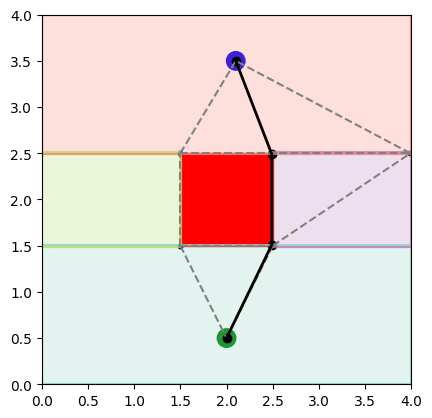

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle
from scipy.spatial import HalfspaceIntersection
from shapely.geometry import LineString
from scipy.optimize import linprog
import cvxpy as cp

# ------------------------------------------------------------------
# 1.  Problem set‑up
# ------------------------------------------------------------------
start = np.array([2, 0.5])
goal  = np.array([2.1, 3.5])

# Axis‑aligned square obstacle, side = 1 m, centred at (2, 2)
obstacle = np.array([
    [1.5, 1.5],
    [2.5, 1.5],
    [2.5, 2.5],
    [1.5, 2.5]
])

world_bounds = np.array([[0, 4], [0, 4]])   # [xmin,xmax], [ymin,ymax]

# ------------------------------------------------------------------
# 2.  Helper: convert an axis‑aligned rectangle → HalfspaceIntersection
# ------------------------------------------------------------------
def rectangle_halfspace(x_min, x_max, y_min, y_max):
    # each row is [a1, a2, offset] for  a·x + offset ≤ 0
    halfspaces = np.array([
        [ 1,  0, -x_max],    #  x ≤ x_max
        [-1,  0,  x_min],    # -x ≤ -x_min   →  x ≥ x_min
        [ 0,  1, -y_max],    #  y ≤ y_max
        [ 0, -1,  y_min]     # -y ≤ -y_min   →  y ≥ y_min
    ])
    interior = np.array([(x_min + x_max)/2, (y_min + y_max)/2])
    return HalfspaceIntersection(halfspaces, interior)

# ------------------------------------------------------------------
# 3.  Manually specified convex regions (no IRIS)
# ------------------------------------------------------------------
eps = 1e-2  # tiny overlap so Qhull sees a 2‑D polytope

regions_bounds = [
    (0.0, 4.0,      0.0, 1.5 + eps),      # south
    (0.0, 4.0,      2.5 - eps, 4.0),      # north
    (0.0, 1.5 + eps,1.5 - eps, 2.5 + eps),# west
    (2.5 - eps, 4.0,1.5 - eps, 2.5 + eps) # east
]

halfspace_reps = [rectangle_halfspace(*rb) for rb in regions_bounds]

# ------------------------------------------------------------------
# 4.  All GCS utilities from your original script
#     (unchanged – only IRIS‑specific pieces were deleted)
# ------------------------------------------------------------------
def order_vertices(points):
    c = np.mean(points, axis=0)
    ang = np.arctan2(points[:,1]-c[1], points[:,0]-c[0])
    return points[np.argsort(ang)]

def draw_region(ax, hs, color):
    verts = order_vertices(hs.intersections)
    ax.add_patch(Polygon(verts, color=color, alpha=0.25))
    ax.plot(*verts.T, color=color, alpha=0.8)
    ax.plot([verts[0,0], verts[-1,0]], [verts[0,1], verts[-1,1]], color=color, alpha=0.8)

# ---------- region intersection / overlap helpers ----------
def point_inside_region(p, hs):          # A·x + b ≤ 0 ?
    return not np.any(hs.halfspaces @ np.hstack((p,1)) > 0)

def edge_edge_intersection(e1, e2):
    return not LineString(e1).intersection(LineString(e2)).is_empty

def do_regions_intersect(r1, r2):
    v1, v2 = order_vertices(r1.intersections), order_vertices(r2.intersections)
    for i in range(len(v1)):
        for j in range(len(v2)):
            if edge_edge_intersection(v1[[i,(i+1)%len(v1)]], v2[[j,(j+1)%len(v2)]]):
                return True
    return False

def construct_overlap_adj_mat(regions):
    n = len(regions) + 2                 # + start, goal
    A = np.zeros((n, n))
    s, g = len(regions), len(regions)+1
    for i,r in enumerate(regions):
        A[i,s] = A[s,i] = point_inside_region(start, r)
        A[i,g] = A[g,i] = point_inside_region(goal,  r)
        for j in range(i+1, len(regions)):
            A[i,j] = A[j,i] = do_regions_intersect(r, regions[j])
    return A

# ---------- half‑space intersection between two regions ----------
def compute_halfspace_intersection(r1, r2):
    hs = np.vstack((r1.halfspaces, r2.halfspaces))
    nrm = np.linalg.norm(hs[:,:-1], axis=1, keepdims=True)
    c   = np.zeros(hs.shape[1]); c[-1] = -1
    A   = np.hstack((hs[:,:-1], nrm)); b = -hs[:,-1:]
    x   = linprog(c, A_ub=A, b_ub=b).x
    return HalfspaceIntersection(hs, x[:-1]), x[:-1]

# ---------- build GCS regions and conjugate graph ----------
def construct_gcs_regions(adj, hs_list):
    s, g = adj.shape[0]-2, adj.shape[0]-1
    idx_map, regions, pts = {}, [], []
    for i in range(adj.shape[0]):
        for j in range(i, adj.shape[1]):
            if adj[i,j]:
                idx_map[(i,j)] = idx_map[(j,i)] = len(regions)
                if s in (i,j):  new_r, p = "start", start
                elif g in (i,j):new_r, p = "goal",  goal
                else:           new_r, p = compute_halfspace_intersection(hs_list[i], hs_list[j])
                regions.append(new_r); pts.append(p)
    pts = np.array(pts)

    # conjugate graph
    m = len(regions)
    G = np.zeros((m, m))
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if adj[i,j]:
                for k in range(adj.shape[0]):
                    if k in (i,j): continue
                    e1 = idx_map[(i,j)]
                    if adj[i,k]: G[e1, idx_map[(i,k)]] = 1
                    if adj[j,k]: G[e1, idx_map[(j,k)]] = 1
    return regions, pts, idx_map, G

# ---------- convex‑relaxed GCS solver (unchanged) ----------
#   … full function solve_gcs_rounding() stays exactly as in your file …

# ------------------------------------------------------------------
# 5.  Build graph and solve
# ------------------------------------------------------------------
adj_mat = construct_overlap_adj_mat(halfspace_reps)
gcs_regions, region_pts, region_map, conjugate = construct_gcs_regions(adj_mat, halfspace_reps)
shortest_path = solve_gcs_rounding(gcs_regions, conjugate)

# ------------------------------------------------------------------
# 6.  Plot
# ------------------------------------------------------------------
fig, ax = plt.subplots()
ax.set_xlim(world_bounds[0]); ax.set_ylim(world_bounds[1])
ax.add_patch(Polygon(obstacle, color="red"))                      # obstacle
ax.add_patch(Circle(start, 0.1, color="green"))                   # start
ax.add_patch(Circle(goal,  0.1, color="blue"))                    # goal

cmap = plt.get_cmap("Set3")
for i, hs in enumerate(halfspace_reps):
    draw_region(ax, hs, cmap(float(i)/len(halfspace_reps)))

ax.scatter(region_pts[:,0], region_pts[:,1], color="k", s=10)     # GCS vertices
for i in range(conjugate.shape[0]):
    for j in range(i, conjugate.shape[1]):
        if conjugate[i,j]:
            ax.plot(region_pts[[i,j],0], region_pts[[i,j],1],
                    color="gray", linestyle="dashed")

if shortest_path:
    sp = np.array(shortest_path)
    ax.plot(sp[:,0], sp[:,1], 'k-', lw=2); ax.scatter(sp[:,0], sp[:,1], color='k')

ax.set_aspect("equal")
plt.show()


In [36]:
import os

# ---------------------------------------------------
# 0.  Setup output folder + start‑x sweep
# ---------------------------------------------------
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

fwd = np.linspace(0.25, 3.75, 30)
bwd = fwd[::-1][1:]
start_xs = np.concatenate([fwd, bwd])
fixed_y  = 0.5

for idx, x in enumerate(start_xs):
    start = np.array([x, fixed_y])
    # goal stays the same
    goal  = np.array([1.9, 3.5])

    # ---------------------------------------------------
    # 1.  (re)build the overlap graph + GCS solve
    # ---------------------------------------------------
    adj_mat = construct_overlap_adj_mat(halfspace_reps)              # uses current `start` & `goal`
    gcs_regions, region_pts, region_map, conjugate = construct_gcs_regions(adj_mat, halfspace_reps)
    shortest_path = solve_gcs_rounding(gcs_regions, conjugate)

    # ---------------------------------------------------
    # 2.  Plot exactly as before
    # ---------------------------------------------------
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(world_bounds[0]); ax.set_ylim(world_bounds[1])
    ax.add_patch(Polygon(obstacle, color="red"))
    ax.add_patch(Circle(start, 0.1, color="green"))
    ax.add_patch(Circle(goal,  0.1, color="blue"))

    # cmap = plt.get_cmap("Set3")
    # for i, hs in enumerate(halfspace_reps):
    #     draw_region(ax, hs, cmap(float(i)/len(halfspace_reps)))

    # ax.scatter(region_pts[:,0], region_pts[:,1], color="k", s=10)
    # for i in range(conjugate.shape[0]):
    #     for j in range(i, conjugate.shape[1]):
    #         if conjugate[i,j]:
    #             ax.plot(region_pts[[i,j],0], region_pts[[i,j],1],
    #                     color="gray", linestyle="dashed", lw=0.8)

    if shortest_path:
        sp = np.array(shortest_path)
        ax.plot(sp[:,0], sp[:,1], 'k-', lw=2)
        ax.scatter(sp[:,0], sp[:,1], color='k', s=20)

    ax.set_aspect("equal")
    # ax.set_title(f"start x = {x:.2f}")
    ax.axis("off")

    # ---------------------------------------------------
    # 3.  Save this frame
    # ---------------------------------------------------
    filename = os.path.join(output_dir, f"frame_{idx:03d}.png")
    plt.savefig(filename, dpi=150, bbox_inches="tight")
    plt.close(fig)

print(f"All frames saved in ./{output_dir}/")


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 17 09:49:46 PM: Your problem has 96 variables, 292 constraints, and 0 parameters.
(CVXPY) Apr 17 09:49:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 09:49:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 09:49:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 09:49:46 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 09:49:46 PM: Compiling problem (target solver=MOSEK).
(

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 17 09:51:59 PM: Your problem has 33228 variables, 120736 constraints, and 0 parameters.
(CVXPY) Apr 17 09:52:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 09:52:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 09:52:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 09:52:00 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 09:52:02 PM: Compiling problem (target solver=MOS

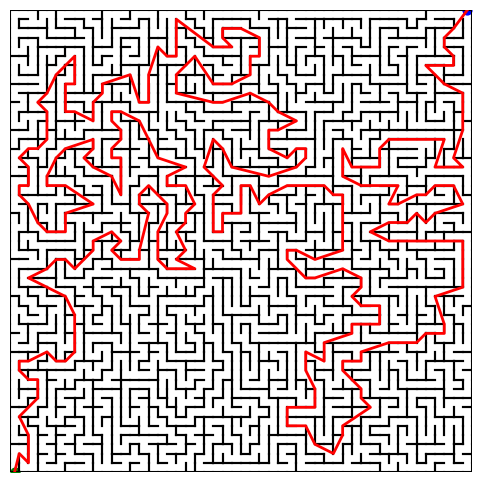

In [39]:
from maze import Maze
# ================================================================
# 0.  Build the maze
# ================================================================
maze_size   = 50
knock_downs = 3

maze = Maze(maze_size, maze_size)   # <- your Maze class
maze.make_maze()
maze.knock_down_walls(knock_downs)

# ================================================================
# 1.  Convert every cell into a convex region
# ================================================================
eps_cell = 1e-3                   # tiny “fattening” so adjacent cells overlap in 2‑D
regions_bounds = []                 # [(xmin,xmax,ymin,ymax), …] per cell
cell_index     = {}                 # (i,j) -> row in regions_bounds

for i in range(maze_size):
    for j in range(maze_size):
        # Inflate the 1×1 square by eps so HalfspaceIntersection works
        xmin, xmax = i   - eps_cell, i+1 + eps_cell
        ymin, ymax = j   - eps_cell, j+1 + eps_cell
        cell_index[(i, j)] = len(regions_bounds)
        regions_bounds.append((xmin, xmax, ymin, ymax))

halfspace_reps = [rectangle_halfspace(*rb) for rb in regions_bounds]

# ================================================================
# 2.  Build the overlap / adjacency matrix from maze walls
# ================================================================
n_regions        = len(regions_bounds)
adj_mat          = np.zeros((n_regions + 2, n_regions + 2))  # + start, goal
START, GOAL      = n_regions, n_regions + 1                  # special rows/cols

start = np.array([0.5, 0.0])                    # just below (0,0) cell
goal  = np.array([maze_size-0.5, maze_size])    # just above (N-1,N-1)

# ---- (a) cell‑to‑cell edges (knocked‑down walls) ----
for i in range(maze_size):
    for j in range(maze_size):
        v_idx = cell_index[(i, j)]
        cell  = maze.get_cell(i, j)
        for dir_name, (di, dj) in maze.directions.items():
            if not cell.walls[dir_name]:        # open passage
                ni, nj       = i + di, j + dj
                if 0 <= ni < maze_size and 0 <= nj < maze_size:
                    w_idx    = cell_index[(ni, nj)]
                    adj_mat[v_idx, w_idx] = adj_mat[w_idx, v_idx] = 1

# ---- (b) connect start / goal to the cell they sit in ----
def cell_containing_point(p):
    i, j = int(np.floor(p[0])), int(np.floor(p[1]))
    return cell_index.get((i, j), None)

start_cell = cell_containing_point([0, 0])      # below (0,0) actually touches it
goal_cell  = cell_containing_point([maze_size-1, maze_size-1])

# start sits just outside (0,0); connect manually to its region
adj_mat[START, start_cell] = adj_mat[start_cell, START] = 1
# goal sits just outside (N-1,N-1)
adj_mat[GOAL,  goal_cell]  = adj_mat[goal_cell,  GOAL]  = 1

# ================================================================
# 3.  Build GCS regions, solve, plot
# ================================================================
gcs_regions, region_pts, _, conjugate = construct_gcs_regions(adj_mat, halfspace_reps)
shortest_path = solve_gcs_rounding(gcs_regions, conjugate)

# ================================================================
# 4.  Quick visual check  (optional)
# ================================================================
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(0, maze_size); ax.set_ylim(0, maze_size)
ax.set_aspect("equal"); ax.axis("off")

# draw maze walls
for i in range(maze_size):
    for j in range(maze_size):
        cell = maze.get_cell(i, j)
        xmin, ymin = i, j
        xmax, ymax = i+1, j+1
        if cell.walls['N']: ax.plot([xmin, xmax], [ymax, ymax], 'k-')
        if cell.walls['S']: ax.plot([xmin, xmax], [ymin, ymin], 'k-')
        if cell.walls['W']: ax.plot([xmin, xmin], [ymin, ymax], 'k-')
        if cell.walls['E']: ax.plot([xmax, xmax], [ymin, ymax], 'k-')

# draw GCS solution
if shortest_path:
    sp = np.array(shortest_path)
    ax.plot(sp[:,0], sp[:,1], 'r-', lw=2)
    ax.scatter(*start, c='green', s=40); ax.scatter(*goal, c='blue', s=40)

plt.show()
